## ANAMOLY DETECTION IN ECG SIGNALS USING BIDIRECTIONAL LSTM VARIATIONAL AUTOENCODERS


Prepare Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras import backend as K
import numpy as np

from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.read_csv('D:/Downloads/ecg (1).csv')



data = df.iloc[:, :-1].values  # ECG data (2D NumPy array)
labels = df.iloc[:, -1].values  # Labels (1D NumPy array)

# Split the data into training and test sets (80% training, 10% test, 10% validation)




train_data, X_temp, train_labels, y_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# Normalize the data (using z-score normalization)
mean1 = np.mean(train_data)
mean2 = np.mean(val_data)
mean3 = np.mean(test_data)

std1 = np.std(train_data)
std2 = np.std(val_data)
std3 = np.std(test_data)


train_data = (train_data - mean1) / std1
val_data= (val_data-mean2)/std2
test_data = (test_data - mean3) / std3






Define the VAE model architecture


In [49]:
import tensorflow as tf
from tensorflow.keras import models,layers

class VAE(tf.keras.Model):
    def __init__(self, input_shape, latent_dim=10):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

           
        self.encoder = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv1D(32, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(2),
            layers.Dropout(0.1),
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.MaxPooling1D(2),
            layers.Dropout(0.1),
            
            # LSTM layer in the encoder
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.Dropout(0.1),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(latent_dim * 2)  # Outputs mean and log variance
        ])
        
        # Decoder
        self.decoder = models.Sequential([
            layers.Dense(64, activation='relu', input_shape=(latent_dim,)),
            layers.Dropout(0.1),
            layers.Dense(35 * 64, activation='relu'),
            # Reshape the output for LSTM layer
            layers.Reshape((35, 64)),
            
            # LSTM layer in the decoder
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.Dropout(0.1),
            
            layers.Conv1DTranspose(64, 3, activation='relu', padding='same'),
            layers.Dropout(0.1),
            layers.UpSampling1D(2),
            layers.Conv1DTranspose(32, 3, activation='relu', padding='same'),
            layers.UpSampling1D(2),
            layers.Conv1DTranspose(1, 3, activation='sigmoid', padding='same')
        ])


        
        
        # Classification head
        self.classifier = models.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])

    
    def encode(self, x):
        # Get mean and log variance from the encoder
        mean_log_var = self.encoder(x)
        mean = mean_log_var[:, :self.latent_dim]
        log_var = mean_log_var[:, self.latent_dim:]
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        # Reparameterization trick
        epsilon = tf.random.normal(shape=(tf.shape(mean)))
        z = mean + tf.exp(0.5 * log_var) * epsilon
        return z
    
    def decode(self, z):
        # Decode from latent space to reconstruct input
        reconstructed = self.decoder(z)
        return reconstructed
    
    def classify(self, z):
        # Predict labels
        predicted_labels = self.classifier(z)
        return predicted_labels
    
    def call(self, x):
        # Forward pass
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        predicted_labels = self.classify(z)
        return reconstructed, predicted_labels, mean, log_var



def custom_loss(y_true, y_pred):
    # Unpack the predictions
    reconstructed = y_pred[0]
    predicted_labels = y_pred[1]
    mean = y_pred[2]
    log_var = y_pred[3]
    
    # Reconstruction loss (MSE)
    recon_loss = tf.reduce_mean(tf.square(y_true[0] - reconstructed))
    
    # KL loss (Kullback-Leibler divergence)
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
    
    # Classification loss (Binary cross-entropy)
    classification_loss = losses.binary_crossentropy(y_true[1], predicted_labels)
    
    # Total loss
    total_loss = recon_loss + kl_loss + abs(classification_loss)
    
    # Remove tf.print statements and use print() for debugging
    print(f"Reconstruction loss: {recon_loss}")
    print(f"KL loss: {kl_loss}")
    print(f"Classification loss: {classification_loss}")
    print(f"Total loss: {total_loss}")
    
    return total_loss





# Create the VAE model instance
input_shape = (140, 1)  # Input shape: (3997, 140, 1)
vae = VAE(input_shape)

# Compile the model
vae.compile(optimizer=optimizers.Adam(), loss='mae')

# Train the model
train_data = train_data  #  (shape: (3997, 140, 1))
train_labels = train_labels  #  (shape: (3997, 1))
test_data = test_data  #  (shape: (1000, 140, 1))
test_labels = test_labels  #  (shape: (1000, 1))

# Training the model
vae.fit([train_data, train_labels], 
        [train_data, train_labels],
        epochs=100, 
        batch_size=16,
        validation_data=([val_data, val_labels], [val_data, val_labels]))

# Evaluate the model on test data
vae.evaluate([test_data, test_labels], [test_data, test_labels])


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.6616 - val_loss: 0.4744
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.4630 - val_loss: 0.4543
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.4421 - val_loss: 0.4659
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.4392 - val_loss: 0.4430
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.4392 - val_loss: 0.4289
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.4292 - val_loss: 0.4303
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.4195 - val_loss: 0.4306
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.4271 - val_loss: 0.4257
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.4228 - val_loss: 0.4233
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.4187 - val_loss: 0.4271
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.4176 - val_loss: 0.4211
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━

0.4132484793663025

Evaluate against test set

In [22]:
test_result = vae.evaluate(test_data, test_labels)

# Check if the test_result is a float (indicating a single metric)
if isinstance(test_result, float):
    print(f"Test Loss: {test_result}")
else:
    # Assuming test_result is a tuple with (loss, accuracy)
    test_loss, test_accuracy = test_result
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5316
Test Loss: 0.5297812223434448


Reconstruct the data and calculate reconstruction errors

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


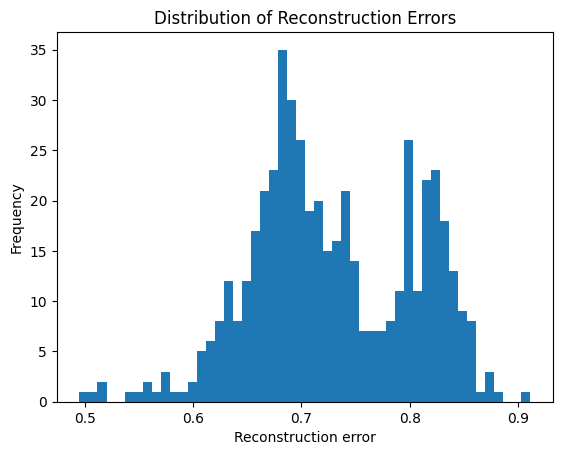

Anomalies found at indices: [  3   5   8   9  11  12  17  19  21  22  23  27  28  32  38  39  41  42
  44  48  51  53  54  55  57  58  59  62  64  65  66  69  71  79  82  85
  90  92  93  96 100 103 111 112 113 115 118 119 121 122 124 125 126 131
 134 136 137 138 141 147 150 152 153 155 156 158 159 163 165 166 173 176
 179 182 186 187 192 193 196 197 198 200 204 205 208 210 211 212 215 217
 223 226 227 228 231 235 236 237 238 244 246 247 249 250 251 252 254 257
 259 260 274 281 283 285 289 290 293 297 298 299 306 311 313 315 316 317
 322 327 328 329 331 335 337 339 341 345 346 349 351 352 353 357 359 360
 364 367 368 369 370 377 391 392 393 400 404 405 407 408 413 414 416 419
 426 427 428 429 432 433 438 441 442 443 446 451 453 454 455 457 460 462
 470 472 475 476 477 478 479 481 486 488 490 491 493 494 499]


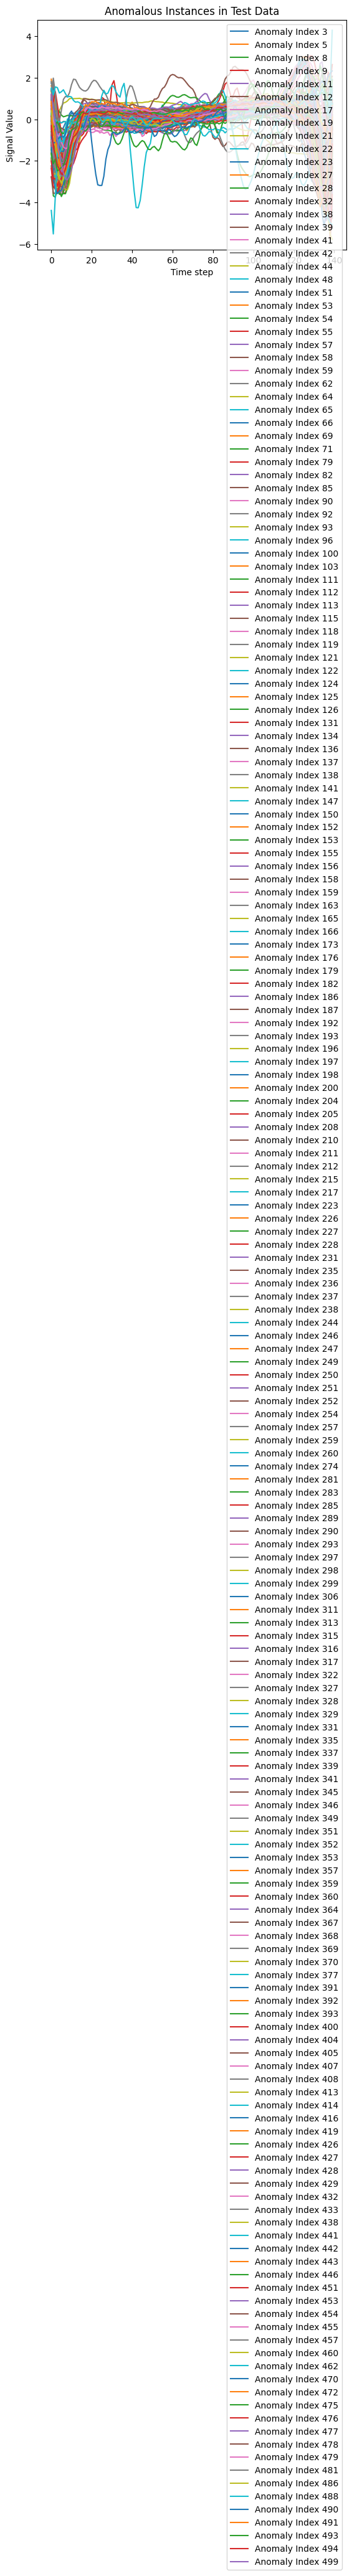

In [50]:
import numpy as np
import matplotlib.pyplot as plt


# Use the trained VAE model to reconstruct test data
reconstructed_data = vae.predict(test_data)
reconstructed_data= reconstructed_data[0]
reconstructed_data = np.squeeze(reconstructed_data, axis=-1)

# Calculate the reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    error = np.mean(np.square(original - reconstructed), axis=1)  # Mean squared error across features
    return error

# Calculate reconstruction errors for the test data
reconstruction_errors = calculate_reconstruction_error(test_data, reconstructed_data)

# Plot the distribution of reconstruction errors
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()



#Getting the indices of anamolies in the test data set
anomalies_indices = np.where(test_labels==0)[0]

# Print the indices of anomalies
print("Anomalies found at indices:", anomalies_indices)

# If you want to visualize the anomalies, you can plot them
for idx in anomalies_indices:
    plt.plot(test_data[idx], label=f'Anomaly Index {idx}')
plt.title('Anomalous Instances in Test Data')
plt.xlabel('Time step')
plt.ylabel('Signal Value')
plt.legend()
plt.show()


Plot the original and reconstructed signal

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


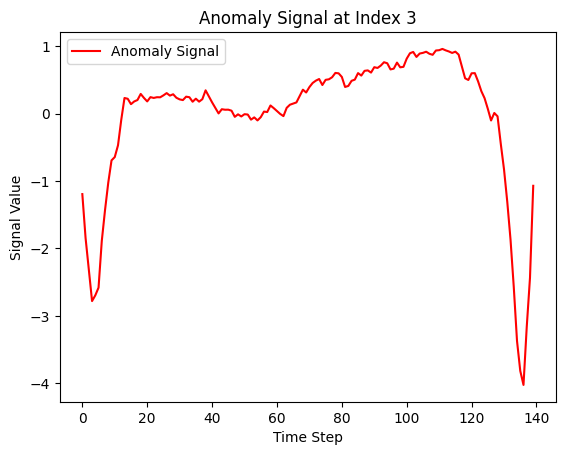

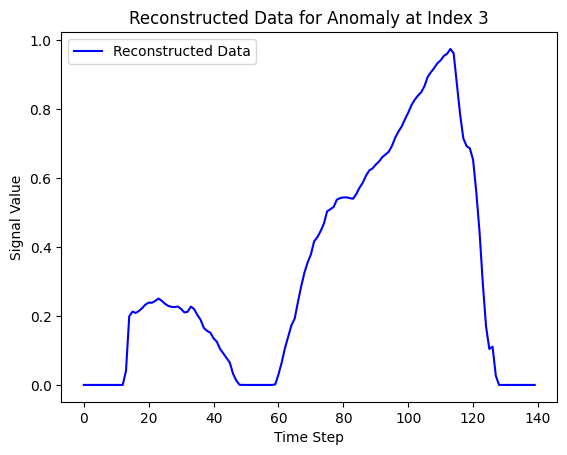

In [51]:
import numpy as np
import matplotlib.pyplot as plt



# Select one anomaly index to plot
anomaly_index = anomalies_indices[0]

# Plot the anomaly signal
plt.figure()
plt.plot(test_data[anomaly_index], label='Anomaly Signal', color='red')
plt.title(f'Anomaly Signal at Index {anomaly_index}')
plt.xlabel('Time Step')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

# Plot the reconstructed data for the anomaly signal
plt.figure()
plt.plot(reconstructed_data[anomaly_index], label='Reconstructed Data', color='blue')
plt.title(f'Reconstructed Data for Anomaly at Index {anomaly_index}')
plt.xlabel('Time Step')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

# Plot other anomalies from the test data


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


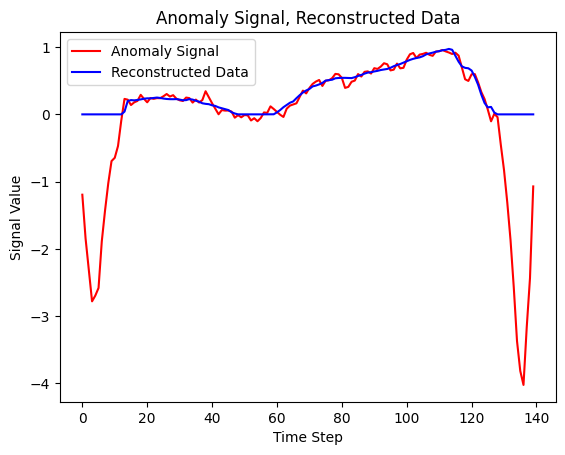

In [52]:
import numpy as np
import matplotlib.pyplot as plt


# Select one anomaly index to plot (you can choose any index from anomalies_indices)
anomaly_index = anomalies_indices[0]

# Plot the anomaly signal, reconstructed data, and other anomalies in a single graph
plt.figure()
# Plot the anomaly signal
plt.plot(test_data[anomaly_index], label='Anomaly Signal', color='red')
# Plot the reconstructed data for the anomaly signal
plt.plot(reconstructed_data[anomaly_index], label='Reconstructed Data', color='blue')
# Plot other anomalies from the test data (excluding the one already plotted)


# Add labels and title
plt.title(f'Anomaly Signal, Reconstructed Data')
plt.xlabel('Time Step')
plt.ylabel('Signal Value')
plt.legend()

# Show the plot
plt.show()


Evaluate the model 

Accuracy: 0.9020
Recall: 0.9541
F1-Score: 0.9223
Precision: 0.9020


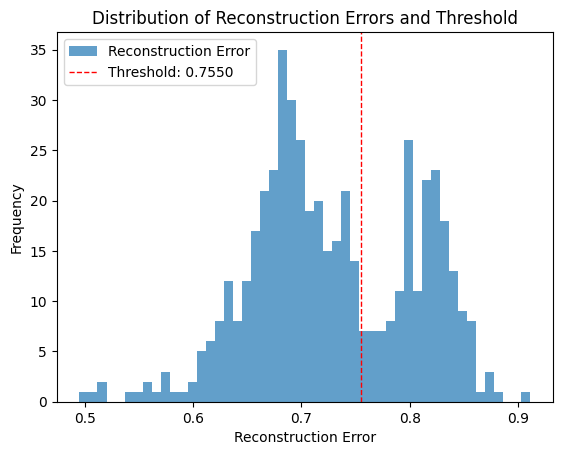

In [66]:
from sklearn.metrics import accuracy_score, recall_score, f1_score,precision_score
import numpy as np
import matplotlib.pyplot as plt
# Pick a threshold based on reconstruction error 
threshold = 0.755
# Predict anomalies based on the threshold
predicted_labels = (reconstruction_errors < threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Calculate recall
recall = recall_score(test_labels, predicted_labels)

# Calculate F1-score
f1 = f1_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Precision: {accuracy:.4f}')

# Optional: Plot the distribution of reconstruction errors and the threshold
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=1, label=f'Threshold: {threshold:.4f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors and Threshold')
plt.legend()
plt.show()